In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data exploration and Cleaning
Suppose you want to build a model to predict the selling price for a home in Socal. You find a dataset which contains current and closed listings. 

The data is stored as a .csv file. CSV stands for Comma-Seperated Values, meaning that each attribute is seperated with a comma.

In python we use the library to read in .csv files into a structure called a dataframe.

In [ ]:
df = pd.read_csv('./socalhousing.csv') #stored in what is called a dataframe

Pandas is packed with lots of useful data exploration commands, we can see the first few rows with .head()

In [ ]:
df.head()

,street,city,bed,bath,price,status,sqft
0,1317 Van Buren Avenue,"Salton City, CA",3,2.0,201900,pending,1560
1,124 C Street W,"Brawley, CA",3,2.0,228500,sold,713
2,2304 Clark Road,"Imperial, CA",3,1.0,273950,for sale,800
3,755 Brawley Avenue,"Brawley, CA",3,1.0,350000,for sale,1082
4,2207 R Carrillo Court,"Calexico, CA",4,3.0,385100,pending,2547


Other useful tools are describe(), hist(), and info() methods. Try each of them and see their functionality in the code cell below.

In [ ]:
# Try describe(), hist(), and info() functions

df.hist()


In the following code cell, plot histogram of the 'sqft' column. You can use hist() function or distplot() from seaborn module.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


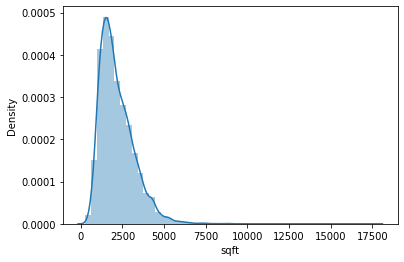

In [ ]:
# Plot histogram of the sqft column
sns.distplot(df['sqft'])

As you can see the min bathroom count is 0 and max is 36, let's investigate further to see if this is an error.

#### Removing faulty rows

In [ ]:
# all that have 0 baths
df[df['bath'] == 0]

,street,city,bed,bath,price,status,sqft
3459,13481 Saint Andrews,"Seal Beach, CA",2,0.0,229000,sold,900
3603,715 Avenida Columbo,"San Clemente, CA",3,0.0,399000,pending,1300
3639,715 Avenida Columbo,"San Clemente, CA",3,0.0,399000,pending,1300
5686,62646 N Starcross Drive,"Desert Hot Springs, CA",3,0.0,281000,sold,2009
9185,159 Velwood Drive,"Redlands, CA",3,0.0,450000,sold,1648
9365,159 Velwood Drive,"Redlands, CA",3,0.0,450000,sold,1648
14542,401 Walbridge Way,"Ojai, CA",5,0.0,1250000,pending,3000
14798,39 Margarita Avenue,"Camarillo, CA",2,0.0,399000,sold,1430
14810,39 Margarita Avenue,"Camarillo, CA",2,0.0,399000,for sale,1430
15390,1475 Forest Drive,"Santa Paula, CA",3,0.0,840000,for sale,2625


In [ ]:
# Find all that have 5 more baths than beds
df[df['bed'] + 5 < df['bath']]

,street,city,bed,bath,price,status,sqft
714,45439 Gingham Avenue,"Lancaster, CA",4,36.0,240000,pending,1229
778,37809 Rudall Avenue,"Palmdale, CA",4,13.0,299000,for sale,1836


Lets drop all these rows.

In [ ]:
indexes= df[ df['bath'] == 0 ].index
df.drop(indexes, inplace=True)

In [ ]:
df[df['bath'] == 0]

,street,city,bed,bath,price,status,sqft


In [ ]:
# Let's also drop rows with # bath > # bed + 5 (that's pretty irregular, unless you have >20 bedrooms)
indexes = df[df['bath'] > df['bed'] + 5].index
df.drop(indexes, inplace=True)

In [ ]:
df[df['bed'] + 5 < df['bath']]

,street,city,bed,bath,price,status,sqft


Now let's see our .describe() once again. Much more reasonable data.

In [ ]:
df.describe()

,bed,bath,price,sqft
count,15461.000000,15461.000000,1.546100e+04,15461.000000
mean,3.506759,2.452144,7.032943e+05,2174.235431
std,1.034919,0.914159,3.769964e+05,1025.540600
min,1.000000,0.100000,1.950000e+05,280.000000
25%,3.000000,2.000000,4.450000e+05,1426.000000
50%,3.000000,2.100000,6.390000e+05,1952.000000
75%,4.000000,3.000000,8.350000e+05,2738.000000
max,12.000000,11.200000,2.000000e+06,17667.000000


From looking at the data we see there are 7 different attribute (1 of which we are trying to predict)
 - street address
 - city 
 - bedroom count
 - bathroom count
 - sqft
 - price
 - status
 

Assume we only want to use the following columns:

- city
- bedroom count
- bathroom count
- sqft


The status column describes whether a house is sold, pending, or for sale.

Since we want to predict only sell prices, we only care about the values for the houses that have been sold, or are pending to be sold. 

We need to drop the rows for the houses still for sale.

We also need to drop the street column and status column as they will not be used in our model.

In [ ]:
indexes= df[ df['status'] == 'for sale' ].index
df.drop(indexes, inplace=True)

# We don't need the status column anymore
df = df.drop(columns=['status'])

# We aren't using the street col, so let's remove it
df = df.drop(columns=['street'])

df.head()

,city,bed,bath,price,sqft
0,"Salton City, CA",3,2.0,201900,1560
1,"Brawley, CA",3,2.0,228500,713
4,"Calexico, CA",4,3.0,385100,2547
5,"Brawley, CA",3,1.0,350000,1082
7,"Brawley, CA",5,2.1,545000,2600


Now we dropped all the unimportant rows in our data.

All of these features seem crucial to determine selling price for a home. However, machine learning models only operate on numbers, we need to convert these columns to numerical values before we can use it! 

Lets start on the city!


#### Numerical data from categorical city data

In [ ]:
df['city'].describe()

count             10316
unique              398
top       San Diego, CA
freq                479
Name: city, dtype: object

Notice that we have 10316 rows but only 398 unique values, this is analogous to your data having 398 different classes, we need to turn this into numbers to continue.


In [ ]:
# Generate a dictionary that maps all unique cities to a unique id
city_dict = {city_name:i for i,city_name in enumerate(df['city'].unique())} 

In [ ]:
# Uses the city dictionary to retrieve the id
def integer_encode_city_name(city_name):
    return city_dict[city_name]

In [ ]:
# Apply the function to the city column and store in new column called city_num
df['city_num'] = df['city'].apply(integer_encode_city_name)

Now our df looks like this, notice how Brawly, CA mapped to 1.

In [ ]:
df.head()

,city,bed,bath,price,sqft,city_num
0,"Salton City, CA",3,2.0,201900,1560,0
1,"Brawley, CA",3,2.0,228500,713,1
4,"Calexico, CA",4,3.0,385100,2547,2
5,"Brawley, CA",3,1.0,350000,1082,1
7,"Brawley, CA",5,2.1,545000,2600,1


Keep in mind that this sort of integer encoding is not great for categorical data since the model might learn arbritrary correlations between the city number and price, etc. So now we can one-hot-encode this in order to avoid these problems!

In [ ]:
# Let's drop the city column since we no longer need it
df = df.drop(columns=["city"])

In [ ]:
df.head()

,bed,bath,price,sqft,city_num
0,3,2.0,201900,1560,0
1,3,2.0,228500,713,1
4,4,3.0,385100,2547,2
5,3,1.0,350000,1082,1
7,5,2.1,545000,2600,1


In [ ]:
# add one-hot encoding
# Use pd.concat to join the new columns with your original dataframe
df = pd.concat([df,pd.get_dummies(df['city_num'], prefix='city_num')],axis=1)

# Now drop the original column (you don't need it anymore)
# df.drop(['city_num'],axis=1, inplace=True)
df.head()

,bed,bath,price,sqft,city_num,city_num_0,city_num_1,city_num_2,city_num_3,city_num_4,city_num_5,city_num_6,city_num_7,city_num_8,city_num_9,city_num_10,city_num_11,city_num_12,city_num_13,city_num_14,city_num_15,city_num_16,city_num_17,city_num_18,city_num_19,city_num_20,city_num_21,city_num_22,city_num_23,city_num_24,city_num_25,city_num_26,city_num_27,city_num_28,city_num_29,city_num_30,city_num_31,city_num_32,city_num_33,city_num_34,...,city_num_358,city_num_359,city_num_360,city_num_361,city_num_362,city_num_363,city_num_364,city_num_365,city_num_366,city_num_367,city_num_368,city_num_369,city_num_370,city_num_371,city_num_372,city_num_373,city_num_374,city_num_375,city_num_376,city_num_377,city_num_378,city_num_379,city_num_380,city_num_381,city_num_382,city_num_383,city_num_384,city_num_385,city_num_386,city_num_387,city_num_388,city_num_389,city_num_390,city_num_391,city_num_392,city_num_393,city_num_394,city_num_395,city_num_396,city_num_397
0,3,2.0,201900,1560,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,2.0,228500,713,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,3.0,385100,2547,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,3,1.0,350000,1082,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,5,2.1,545000,2600,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now our data is all numerical!

### Feature Engineering
We can often create our own features from the data we have if we think we can add some important information that the model then doesn't have to spend time learning.

For example, **price per square foot** or **bath to bed ratio** are two pretty good features that may help with price prediction.

Adding these in as inputs may seem redundant, but it also means the model doesn't have to learn these functions, which can speed up training.

Let's add the price per square foot column.

In [ ]:
# Add price per square foot column
df['ppsqft'] = df['price']/df['sqft']
df['bbr'] = df['bath']/df['bed']

In [ ]:
df.head()

,bed,bath,price,sqft,city_num,city_num_0,city_num_1,city_num_2,city_num_3,city_num_4,city_num_5,city_num_6,city_num_7,city_num_8,city_num_9,city_num_10,city_num_11,city_num_12,city_num_13,city_num_14,city_num_15,city_num_16,city_num_17,city_num_18,city_num_19,city_num_20,city_num_21,city_num_22,city_num_23,city_num_24,city_num_25,city_num_26,city_num_27,city_num_28,city_num_29,city_num_30,city_num_31,city_num_32,city_num_33,city_num_34,...,city_num_360,city_num_361,city_num_362,city_num_363,city_num_364,city_num_365,city_num_366,city_num_367,city_num_368,city_num_369,city_num_370,city_num_371,city_num_372,city_num_373,city_num_374,city_num_375,city_num_376,city_num_377,city_num_378,city_num_379,city_num_380,city_num_381,city_num_382,city_num_383,city_num_384,city_num_385,city_num_386,city_num_387,city_num_388,city_num_389,city_num_390,city_num_391,city_num_392,city_num_393,city_num_394,city_num_395,city_num_396,city_num_397,ppsqft,bbr
0,3,2.0,201900,1560,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129.423077,0.666667
1,3,2.0,228500,713,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,320.476858,0.666667
4,4,3.0,385100,2547,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,151.197487,0.750000
5,3,1.0,350000,1082,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,323.475046,0.333333
7,5,2.1,545000,2600,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,209.615385,0.420000


### Data Normalizing/Standardization

We are almost ready to feed this into our model!

Before we do we need to do something important, normalize.

Normalizing data is the process of bounding your inputs into a range, most commonly [0,1]. It can be done with:
$$x \to_{norm}  \frac{x - \min}{\max - \min}$$

Standardizing data is making your data have a zero mean and unit variance. This can be done with:

$$x \to_{stdize}  \frac{x - \mu}{\sigma}$$
Where $\mu$ is your mean and $\sigma$ is your standard deviation.

The rule of thumb is, if your data distribution is normal (bell curve), then standardize, otherwise normalize.

This is important because our features vary hugely in magnitude, for example the sqft is in the thousands compared to the number of beds and baths.


#### Which ones should be normalized and which should be standardized?

In [ ]:
def normalize_col(col):
    return (col - col.min())/(col.max() - col.min())

def standardize_col(col):
    return (col - col.mean()) / col.std()

bed


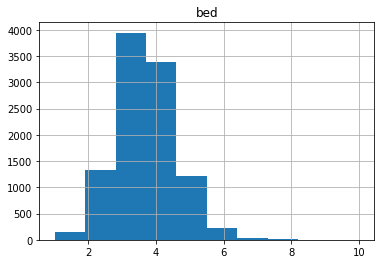

bath


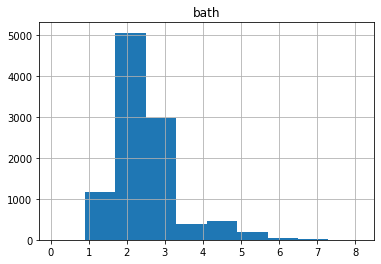

price


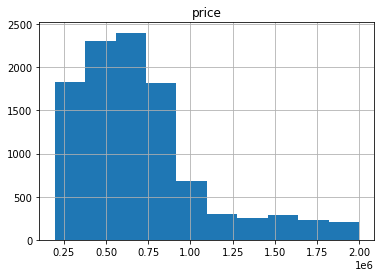

sqft


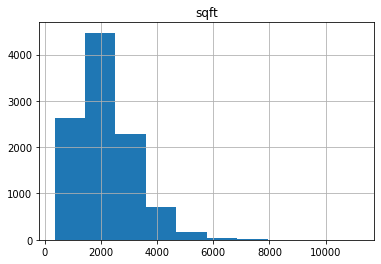

ppsqft


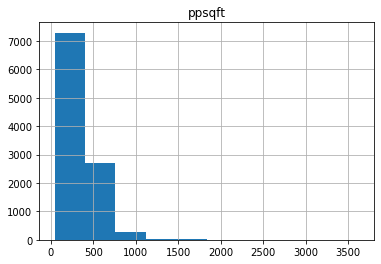

bbr


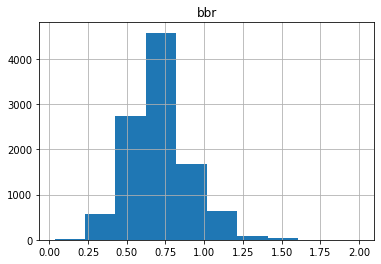

In [ ]:
for col in df:
  if 'city_num' in col:
    continue
  else:
    print(col)
    df.hist(column=col)
    plt.show()

As you can see, pretty much all but city_num mimic a normal distribution, we should therfore standardize our data.

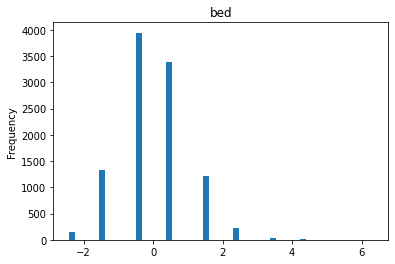

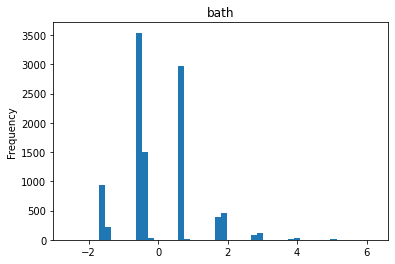

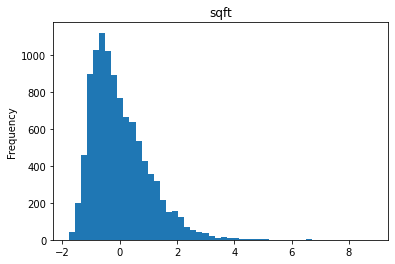

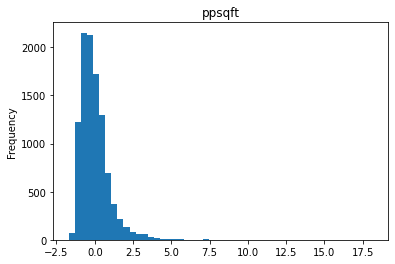

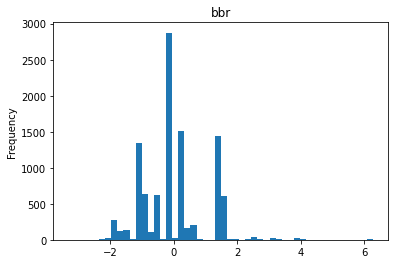

In [ ]:
# Let's do the rest
for col in df:
    if 'city_num' in col or col == 'price': 
        # We don't want to standardize city_num, since these are categories.
        # or price since it's our target
        continue
    # Standardize columns
    df[col] = standardize_col(df[col])
    # Plot data again
    df[col].plot.hist(bins = 50, title = col)
    plt.show()
   

Now we are ready to use this data!